## Very Simple Markov Perfect Industry Dynamics in Python

#### John Stachurski

In this note we implement the algorithm for computing Markov perfect equilibria presented and analyzed in the paper [Very Simple Markov-Perfect Industry Dynamics: Theory
](https://www.econometricsociety.org/publications/econometrica/2018/03/01/very-simple-markov-perfect-industry-dynamics-theory) 

The paper, written by Jaap H. Abbring, Jeffrey R. Campbell, Jan Tilly, and Nan Yang, is published in the March 2018 issue of Econometrica

Our implementation of their algorithm uses Python

We exploit Numba and JIT compilation to generate fast, efficient machine code for computation of the equilibrium

Rather than discretizing the exogenous state, we treat it as continuous and apply linear interpolation where necessary

In addition to implementing the algorithm, we run some simulations to help build intuition as to the predictions of the model

Two great things about this particular model of oligopolistic competition are:

1. unlike many related papers, a unique symmetric Markov perfect algorithm is shown to exist and, 

2. the authors provide an algorithm guaranteed to converge to this equilibrium.

### Set Up

We begin with some miscellaneous imports:

In [1]:
import numpy as np
import quantecon as qe
from numba import njit
from lininterp import interp1d
from scipy.special import binom
from scipy.optimize import brentq, bisect

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D
from matplotlib import cm


The state process is

$$ y_{t+1} = \rho y_t + b + \xi_{t+1} $$

where $-1 < \rho < 1$ and $\{ \xi_t \}$ is iid and uniform on $[-\sigma, \sigma]$


The parameters in this process are set to

In [2]:
ρ = 0.98
b = 10.0
σ = 2.0

Iterating on the bound $y_{t+1} \leq \rho y_t + b + \sigma$ yields

$$
    y_{t+1} \leq (b + \sigma) \frac{1 - \rho^{t+1}}{1 - \rho} + \rho^{t+1} y_0
$$

Taking the limit in this expression and then repeating the exercise with the reverse bound $y_{t+1} \geq \rho y_t + b - \sigma$, we find
that the stationary distribution for $y_t$ is supported on the interval

$$ I := \left[ \frac{b - \sigma}{1 - \rho}, \, \frac{b + \sigma}{1 - \rho} \right] $$

Let's set up a grid over $y$ values, covering the stationary distribution, which we can use to interpolate functions over:

In [3]:
y_min = (b - σ) / (1 - ρ)
y_max = (b + σ) / (1 - ρ)
y_grid_size = 12
y_grid = np.linspace(y_min, y_max, y_grid_size)

We'll use draws from the innovation $\xi$ to integrate via Monte Carlo:

In [4]:
mc_size = 250
ξ_draws = np.random.uniform(low=-σ, high=σ, size=mc_size)

The discount rate is

In [5]:
β = 0.9

Entry costs are increasing in the number of firms and decreasing in the state:

In [6]:
@njit
def ϕ(n, y):
    return np.exp(4.0 * n - 0.5 * y)

The profit function $\pi$ is decreasing in the number of firms and increasing in the exogenous state:

$$ \pi(n, y) = d y^q - n^\gamma $$

In [7]:
d = 1.0
γ = 2.0
q = 1.25

@njit
def π(n, y):
    return d * y**q - n**γ

Set `n_max` to the first $n$ such that profits are negative for all possible values of $y_t$.

In [8]:
n_max = np.int(np.ceil( (d * y_max**q)**(1/γ) ))
n_size = n_max + 1

In [9]:
n_max

55

In the text, as in the original paper, `n_max` will be represented by $\check n$.

### Algorithm for Computing the Equilibrium

We use the algorithm described in Abbring et al. (2018)

As in that paper, $v_E(j, y)$ is the post-entry stage value of firm number $j$ in exogenous state $y$

Here, to match Python indexing, the first firm given the option to enter will be labeled "firm 0" rather than "firm 1"

First we solve for $v_E(\check n, \cdot)$ as the fixed point of

$$ (Tf)(y) = 
   \max 
   \left\{
       0, \, \beta \, \mathbb E_y 
        [ \pi(\check n, Y') + 
           f(Y')
        ]
   \right\}
$$
         

Next, for $n = \check n -1, \check n - 2, \ldots, 1$, we solve the family of contractions

$$ (T_n f)(y) = 
   \max 
   \left\{
       0, \, \beta  \, \mathbb E_y 
        [ \pi(n, Y') + 
           \mathbb 1\{\mu(n, Y') = n\} f(Y') +
           \mathbb 1\{\mu(n, Y') > n\} g_n(Y')
        ]
   \right\}
$$

Here

* $g_n(Y') := v_E(\mu(n, Y'), Y')$
* $\mu(n, y) := n + \sum_{m=n+1}^{\check n} \mathbb 1\{v_E(m, y) > \phi(m, y)\}$ where $v_E(m, \cdot)$ is the fixed point of $T_m$

The expectations above will be approximated by Monte Carlo estimates of the form

$$
    \hat E_y [ h(Y')]
     := \frac{1}{m} \sum_{i=1}^m
         [ h( \rho y + b + \xi_i) ]
$$


Here's a function that computes $\mu(n, y)$ given $v_E$:

In [10]:
@njit
def μ(n, y, v_E):
    μ_n = n
    if n < n_max:
        for m in range(n + 1, n_size):  
            if interp1d(y_grid, v_E[m, :], y) > ϕ(m, y):
                μ_n += 1
    return μ_n

Next, we provide a function factory, the job of which is to

* take $v_E$ and $n$ as inputs, and
* create a Bellman operator $T_n$ corresponding to the definition given above

The Bellman operator will be jitted using `@njit`

In [11]:
def build_bellman_operator(v_E, n):
    
    @njit
    def firm_bellman(f_in):
        # Set up
        def f(x):
            return interp1d(y_grid, f_in, x)
        f_out = np.empty_like(f_in)

        for i, y in enumerate(y_grid):
            t = 0.0
            for ξ in ξ_draws:
                yp = ρ * y + b + ξ
                t += π(n, yp) 
                μ_n = μ(n, yp, v_E)
                if μ_n == n:
                    t += f(yp)
                else:
                    t += interp1d(y_grid, v_E[μ_n, :], yp)
            f_out[i] = max(0, β * (t / mc_size))
        return f_out
    
    return firm_bellman


Here's a function to iterate to convergence with each $T_n$, starting at initial condition $f \equiv 0$

The function returns the (approximate) fixed point of $T_n$

In [12]:
def iterate(operator, f_init, tol=0.0001, max_iter=500, verbose=True):
    error = tol + 1
    i = 0
    f_in = f_init
    while i < max_iter and error > tol:
        f_out = operator(f_in)
        error = np.max(np.abs(f_out - f_in))
        f_in = f_out
        i += 1
    if verbose:
        print(f'  Iteration converged after {i} step(s)')
    return f_out

The decision to enter for firm $n$ in state $y$ is represented by $\alpha_E(n, y) = 1$ where

$$ \alpha_E(n, y) = \mathbb 1\{v_E(n, y) > \phi(n, y) \} $$

Here's an implementation, taking $v_E$ as given

In [13]:
def α_E(n, y, v_E): 
    α = 0
    if interp1d(y_grid, v_E[n, :], y) > ϕ(n, y):
        α = 1
    return α

The next function computes the number of entrants when the number of incumbents is zero.

In [14]:
def N_E(y, v_E):
    num_entrants = 0
    for n in range(n_size):
        num_entrants += α_E(n, y, v_E)
    return num_entrants

### Computation of Equilibrium Values and Actions

Now let's use the code above to compute the equilibrium corresponding to our parameters



In [15]:
v_E = np.empty((n_size, y_grid_size))

n = n_max
f_init = np.zeros(y_grid_size)
while n >= 0:
    print(f"Solving v_E(n, ) for firm {n}")
    operator = build_bellman_operator(v_E, n)
    f_out = iterate(operator, f_init)
    v_E[n, :] = f_out
    n = n - 1


Solving v_E(n, ) for firm 55
  Iteration converged after 1 step(s)
Solving v_E(n, ) for firm 54
  Iteration converged after 59 step(s)
Solving v_E(n, ) for firm 53
  Iteration converged after 43 step(s)
Solving v_E(n, ) for firm 52
  Iteration converged after 36 step(s)
Solving v_E(n, ) for firm 51
  Iteration converged after 29 step(s)
Solving v_E(n, ) for firm 50
  Iteration converged after 21 step(s)
Solving v_E(n, ) for firm 49
  Iteration converged after 17 step(s)
Solving v_E(n, ) for firm 48
  Iteration converged after 13 step(s)
Solving v_E(n, ) for firm 47
  Iteration converged after 2 step(s)
Solving v_E(n, ) for firm 46
  Iteration converged after 13 step(s)
Solving v_E(n, ) for firm 45
  Iteration converged after 10 step(s)
Solving v_E(n, ) for firm 44
  Iteration converged after 9 step(s)
Solving v_E(n, ) for firm 43
  Iteration converged after 7 step(s)
Solving v_E(n, ) for firm 42
  Iteration converged after 2 step(s)
Solving v_E(n, ) for firm 41
  Iteration converged af

In studying the equilibrium, let's start by looking at the number of entrants for each level of the exogeneous shock.

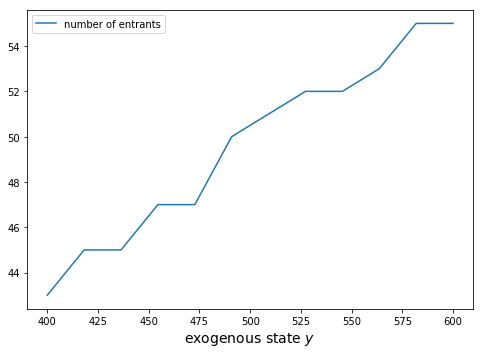

In [16]:

fig, ax = plt.subplots(figsize=(8, 5.5))
ax.plot(y_grid, [N_E(y, v_E) for y in y_grid], label='number of entrants')
ax.legend()
ax.set_xlabel('exogenous state $y$', fontsize=14)
plt.show()

Not surprisingly, a higher exogenous state draws in more firms

Next, let's look at $v_E$, which is a function of the exogenous state and the firm number $j$

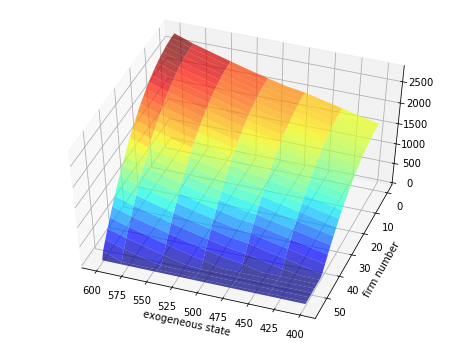

In [17]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ng, yg = np.meshgrid(list(range(n_size)), y_grid)
ax.plot_surface(yg,
                ng,
                v_E.T,
                rstride=2, cstride=2,
                cmap=cm.jet,
                alpha=0.7,
                linewidth=0.25)
ax.view_init(50, 110)
ax.set_ylabel("firm number")
ax.set_xlabel("exogeneous state")
plt.show()

Here value is monotone in the exogenous state $y$ for each firm but this isn't always the case

The reason is that a higher value of $y$ encourages greater entry, as seen above

Greater entry reduces value for encumbent firms

Now let's build and plot $v_S$

In [18]:
v_S = np.empty((n_size, y_grid_size))
for n in range(n_size):
    for i, y in enumerate(y_grid):
        t = 0.0
        for ξ in ξ_draws:
            yp = ρ * y + b + ξ
            t += π(n, yp) + interp1d(y_grid, v_E[μ(n, y, v_E), :], yp)
        v_S[n, i] = t / mc_size

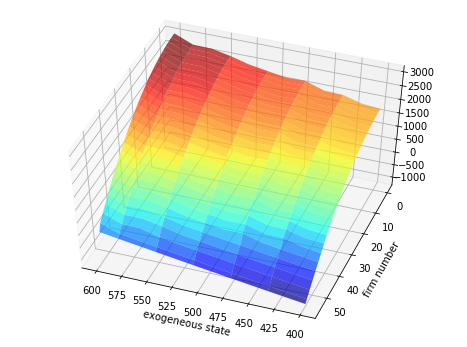

In [19]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ng, yg = np.meshgrid(list(range(n_size)), y_grid)
ax.plot_surface(yg,
                ng,
                v_S.T,
                rstride=2, cstride=2,
                cmap=cm.jet,
                alpha=0.7,
                linewidth=0.25)
ax.view_init(50, 110)
ax.set_ylabel("firm number")
ax.set_xlabel("exogeneous state")
plt.show()

Finally, let's compute the mixed strategy of firms at the survival stage

By the discussion on page 728 of the paper, if $v_S(1, y) \leq 0$ then we set $\alpha_S(n_E, y) = 0$

if $v_S(n_E, y) > 0$ then we set $\alpha_S(n_E, y) = 1$

Otherwise, we need to solve for $a = \alpha_S(n_E, y)$ in

$$
    \sum_{n=1}^{n_E} 
    \binom{n_E - 1}{n - 1}
    a^{n-1}
    (1 - a)^{n_E - n}
    v_S(n, y) = 0
$$

This value solves the indifference condition between exiting and surviving

Once we have this value, we draw the number of survivors from the binomial distribution $B(n_E, a)$

In [20]:
def α_S(n_E, y):
    
    if n_E > n_max:
        return 0    
    if interp1d(y_grid, v_S[1, :], y) <= 0:
        return 0
    if interp1d(y_grid, v_S[n_E, :], y) > 0:
        return 1
    
    def g(a):
        val = 0.0
        for n in range(1, n_E+1):
            vs = interp1d(y_grid, v_S[n, :], y)
            val += binom(n_E-1, n-1) * a**(n-1) * (1 - a)**(n_E-n) * vs
        return val
    
    return bisect(g, 0, 1)
        
    

### Simulation of States

Let's simulate the time path for $(N_t, Y_t)$ 

We won't bother to JIT compile our code, since the computation will be short

Here's a function to draw $(N_{t+1}, Y_{t+1})$ given $(N_t, Y_t) = (n, y)$

In [21]:
def update_state(n, y):
    
    n_E = μ(n, y, v_E)
    a = α_S(n_E, y)
    Np = np.random.binomial(n_E, a)
    yp = ρ * y + b + np.random.uniform(low=-σ, high=σ)
    
    return Np, yp

Now we can simulate and plot the state process:

In [22]:
n_init = 40
y_init = 450
ts_length = 600
n_vec = []
y_vec = []

n, y = n_init, y_init
for i in range(ts_length):
    n_vec.append(n)
    y_vec.append(y)
    n, y = update_state(n, y)

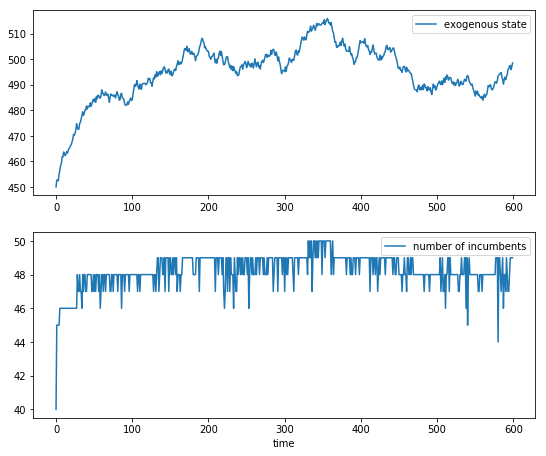

In [23]:
fig, axes = plt.subplots(2, 1, figsize=(9, 7.5))
ax0, ax1 = axes.flatten()
ax1.plot(n_vec, label='number of incumbents')
ax0.plot(y_vec, label='exogenous state')

for ax in ax0, ax1:
    ax.legend()
ax1.set_xlabel("time")

plt.show()

The process looks to be jointly stationary and ergodic -- perhaps someone can write a proof?